In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

def save_dataset(dataset, path, sep=';', index=False, encoding='utf-8-sig'):
    dataset.to_csv(path, sep=sep, index=index, encoding=encoding)

subjects_bak_spec = read_dataset("../../data/datasets/subjects_bak_spec.csv")
subjects_magistr = read_dataset("../../data/datasets/subjects_magistr.csv")

In [98]:
from sklearn.ensemble import IsolationForest

def detect_outliers_isolation_forest(df, target_col='Таргет', contamination=0.05):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outliers = iso_forest.fit_predict(X_scaled) == -1

    print(f"Найдено {sum(outliers)} выбросов методом Isolation Forest")
    return outliers

In [99]:
from sklearn.neighbors import LocalOutlierFactor

def detect_outliers_lof(df, target_col='Таргет', n_neighbors=20, contamination=0.05):
    X = df.drop(columns=[target_col])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(X_scaled) == -1

    print(f"Найдено {sum(outliers)} выбросов методом LOF")
    return outliers

In [100]:
from sklearn.cluster import DBSCAN

def detect_outliers_dbscan(df, target_col='Таргет', eps=3, min_samples=5):
    X = df.drop(columns=[target_col])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)
    
    outliers = clusters == -1

    print(f"Найдено {sum(outliers)} выбросов методом DBSCAN")
    return outliers

In [101]:
import numpy as np
from scipy.stats import chi2

def detect_outliers_mahalanobis(df, target_col='Таргет', alpha=0.01, reg_eps=1e-6):
    X = df.drop(columns=[target_col]).values

    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)

    cov_reg = cov + reg_eps * np.eye(cov.shape[0])

    try:
        inv_cov = np.linalg.inv(cov_reg)
    except np.linalg.LinAlgError:
        raise ValueError("Матрица всё ещё вырожденная даже после регуляризации.")

    dists = []
    for i in range(X.shape[0]):
        diff = X[i] - mean
        dist = diff.T @ inv_cov @ diff
        dists.append(dist)

    threshold = chi2.ppf(1 - alpha, df=X.shape[1])
    outliers = np.array(dists) > threshold

    print(f"Найдено {sum(outliers)} выбросов методом Mahalanobis")
    return outliers

In [102]:
def plot_outliers_with_tsne(X, y, outliers_mask, title="t-SNE с выбросами"):
    X = np.array(X)
    y = np.array(y)
    outliers_mask = np.array(outliers_mask)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X)

    class_0 = y == 0
    class_1 = y == 1

    non_outliers = ~outliers_mask

    idx_0_non_outlier = class_0 & non_outliers
    idx_0_outlier = class_0 & outliers_mask
    idx_1_non_outlier = class_1 & non_outliers
    idx_1_outlier = class_1 & outliers_mask

    counts = {
        'class_0_non_outlier': np.sum(idx_0_non_outlier),
        'class_0_outlier': np.sum(idx_0_outlier),
        'class_1_non_outlier': np.sum(idx_1_non_outlier),
        'class_1_outlier': np.sum(idx_1_outlier),
    }

    plt.figure(figsize=(10, 6))

    plt.scatter(X_tsne[idx_0_non_outlier, 0], X_tsne[idx_0_non_outlier, 1],
                c='#ffcccc', label=f'Класс 0, не выброс ({counts["class_0_non_outlier"]})',
                edgecolor='k', s=60)
    plt.scatter(X_tsne[idx_0_outlier, 0], X_tsne[idx_0_outlier, 1],
                c='red', label=f'Класс 0, выброс ({counts["class_0_outlier"]})',
                edgecolor='k', s=80)

    plt.scatter(X_tsne[idx_1_non_outlier, 0], X_tsne[idx_1_non_outlier, 1],
                c='#cce5ff', label=f'Класс 1, не выброс ({counts["class_1_non_outlier"]})',
                edgecolor='k', s=60)
    plt.scatter(X_tsne[idx_1_outlier, 0], X_tsne[idx_1_outlier, 1],
                c='blue', label=f'Класс 1, выброс ({counts["class_1_outlier"]})',
                edgecolor='k', s=80)

    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [103]:
outliers_if_bak_spec = detect_outliers_isolation_forest(subjects_bak_spec)
outliers_if_magistr = detect_outliers_isolation_forest(subjects_magistr)

outliers_lof_bak_spec = detect_outliers_lof(subjects_bak_spec)
outliers_lof_magistr = detect_outliers_lof(subjects_magistr)

outliers_db_bak_spec = detect_outliers_dbscan(subjects_bak_spec)
outliers_db_magistr = detect_outliers_dbscan(subjects_magistr)

outliers_mah_bak_spec = detect_outliers_mahalanobis(subjects_bak_spec)
outliers_mah_magistr = detect_outliers_mahalanobis(subjects_magistr)

Найдено 81 выбросов методом Isolation Forest
Найдено 34 выбросов методом Isolation Forest
Найдено 81 выбросов методом LOF
Найдено 34 выбросов методом LOF
Найдено 333 выбросов методом DBSCAN
Найдено 99 выбросов методом DBSCAN
Найдено 181 выбросов методом Mahalanobis
Найдено 39 выбросов методом Mahalanobis


In [104]:
X_bak_spec = subjects_bak_spec.drop(columns=['Таргет'])
y_bak_spec = subjects_bak_spec['Таргет']
X_magistr = subjects_magistr.drop(columns=['Таргет'])
y_magistr = subjects_magistr['Таргет']
scaler_bak_spec = StandardScaler()
scaler_magistr = StandardScaler()
X_scaled_bak_spec = scaler_bak_spec.fit_transform(X_bak_spec)
X_scaled_magistr = scaler_magistr.fit_transform(X_magistr)

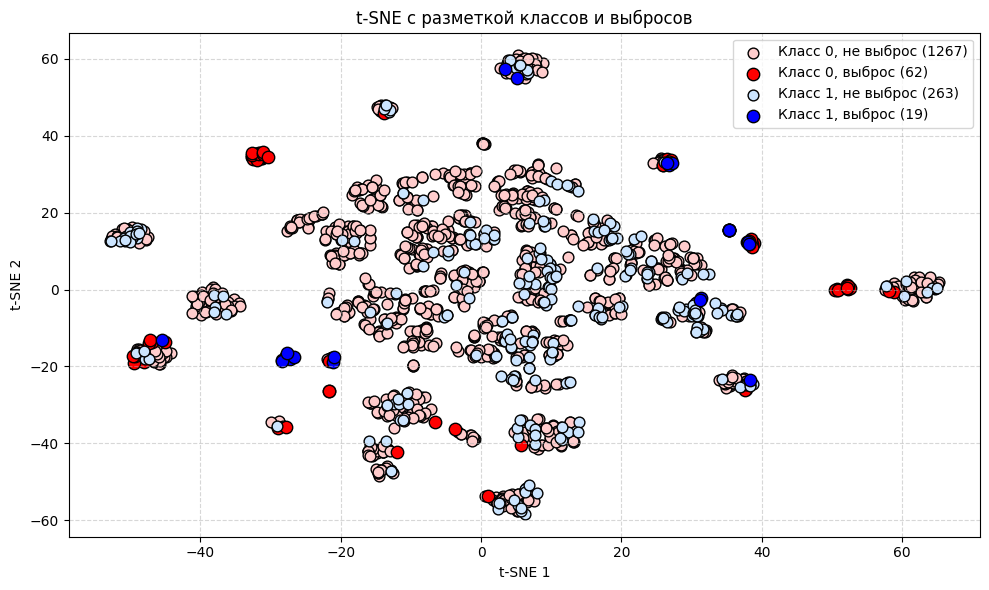

In [105]:
plot_outliers_with_tsne(X_scaled_bak_spec, y_bak_spec, outliers_if_bak_spec, title="t-SNE с разметкой классов и выбросов")

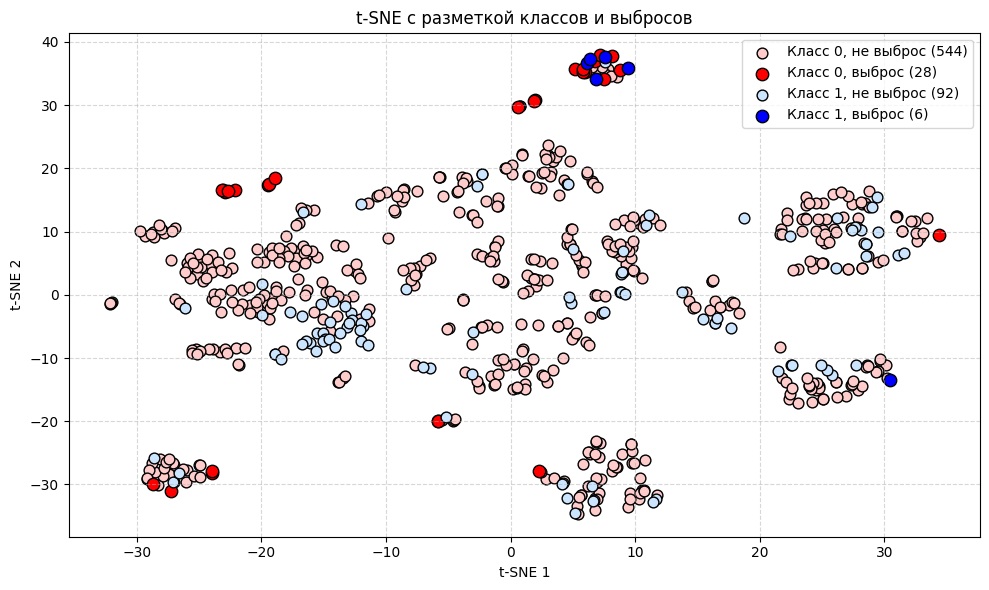

In [106]:
plot_outliers_with_tsne(X_scaled_magistr, y_magistr, outliers_if_magistr, title="t-SNE с разметкой классов и выбросов")

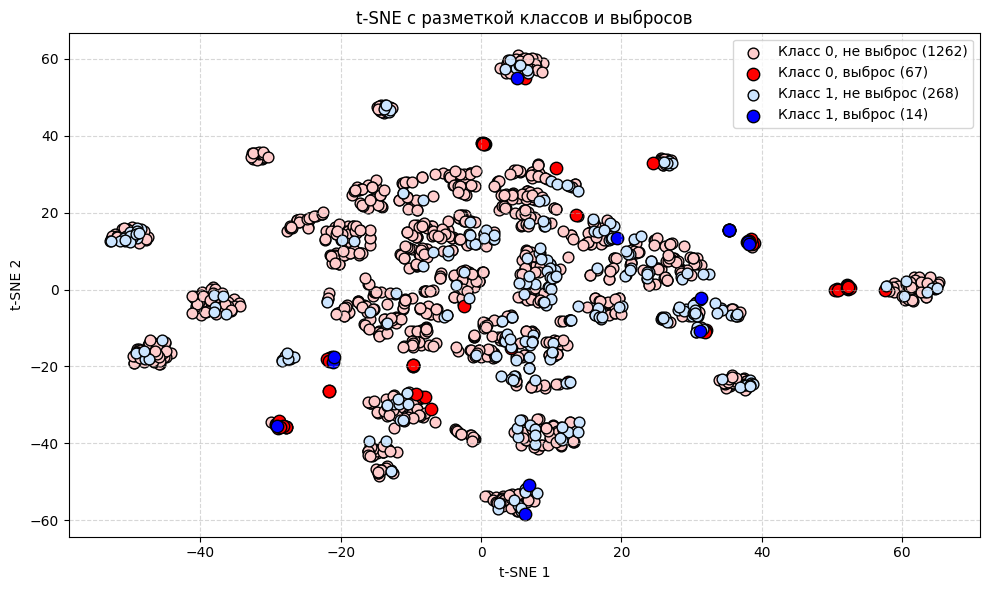

In [107]:
plot_outliers_with_tsne(X_scaled_bak_spec, y_bak_spec, outliers_lof_bak_spec, title="t-SNE с разметкой классов и выбросов")

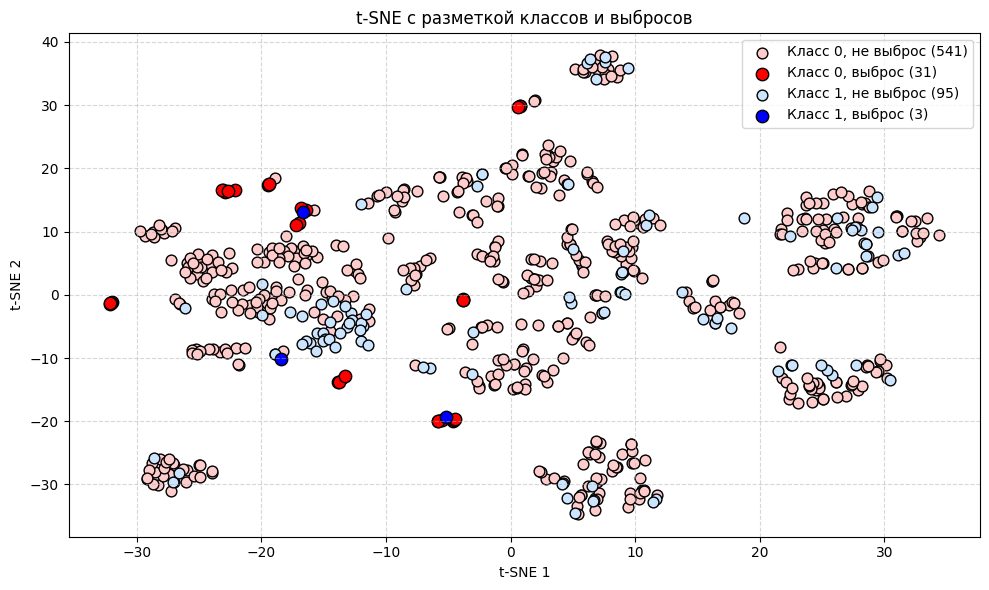

In [108]:
plot_outliers_with_tsne(X_scaled_magistr, y_magistr, outliers_lof_magistr, title="t-SNE с разметкой классов и выбросов")

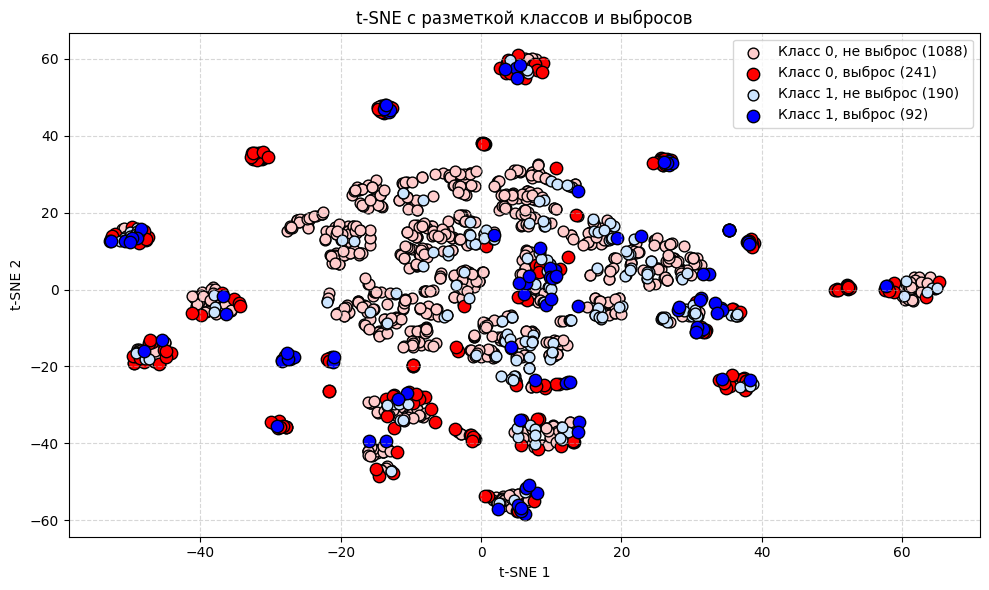

In [109]:
plot_outliers_with_tsne(X_scaled_bak_spec, y_bak_spec, outliers_db_bak_spec, title="t-SNE с разметкой классов и выбросов")

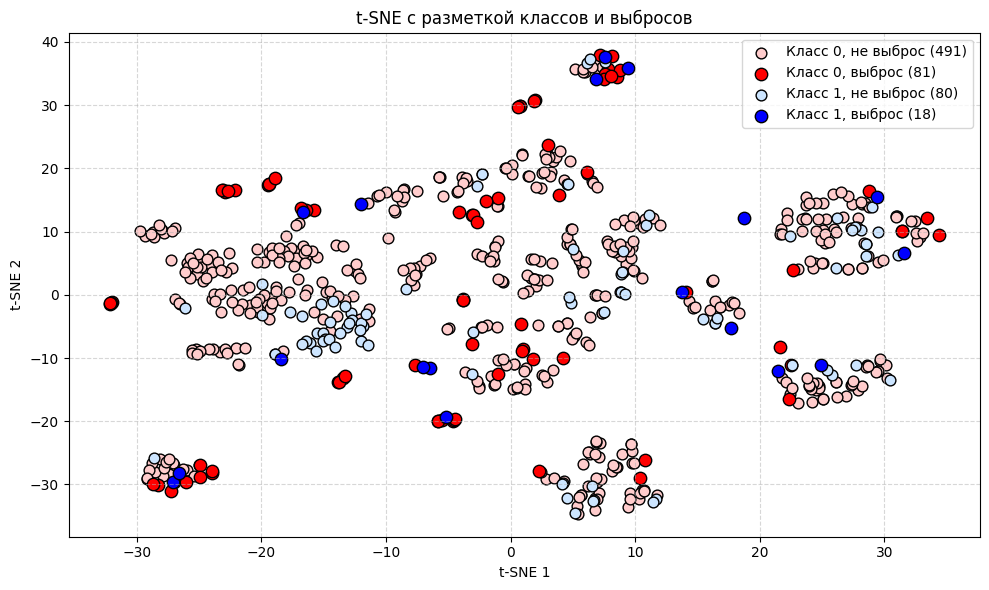

In [110]:
plot_outliers_with_tsne(X_scaled_magistr, y_magistr, outliers_db_magistr, title="t-SNE с разметкой классов и выбросов")

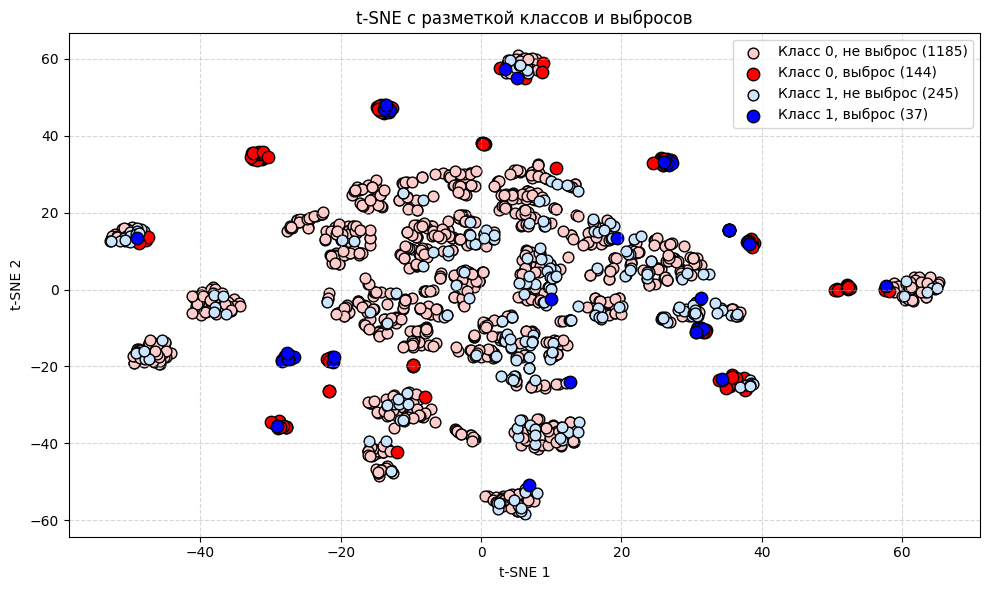

In [111]:
plot_outliers_with_tsne(X_scaled_bak_spec, y_bak_spec, outliers_mah_bak_spec, title="t-SNE с разметкой классов и выбросов")

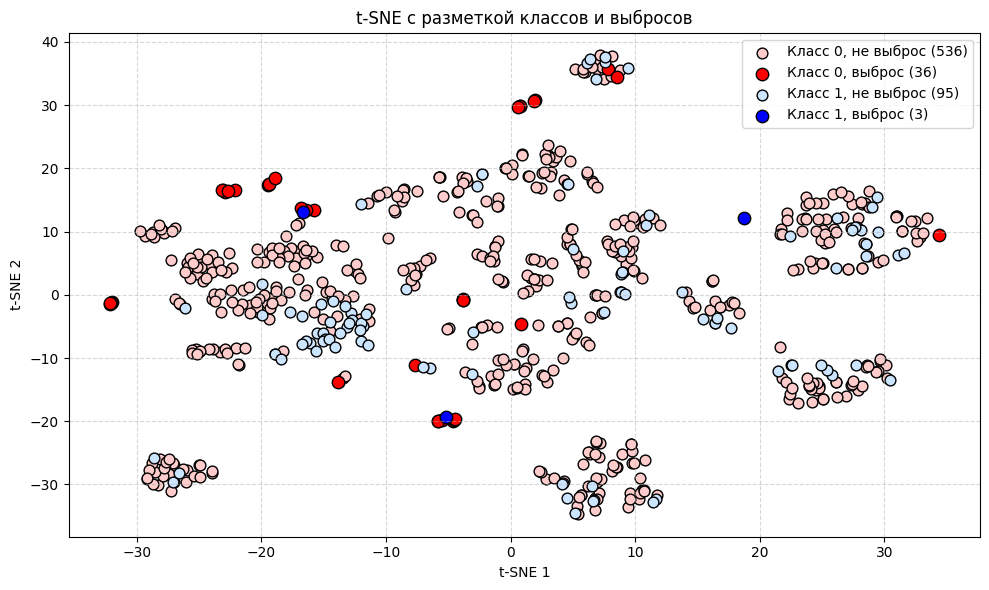

In [112]:
plot_outliers_with_tsne(X_scaled_magistr, y_magistr, outliers_mah_magistr, title="t-SNE с разметкой классов и выбросов")

In [113]:
def filter_and_save_dataset(df, outlier_mask, save_path, save_func=save_dataset):
    filtered_df = df[~outlier_mask]
    save_func(filtered_df, save_path)
    print(f"Фильтрованный датасет сохранён: {save_path}")

In [114]:
bak_spec_if_path = "../../data/datasets/filtered/subjects_bak_spec_filtered_if.csv"
bak_spec_lof_path = "../../data/datasets/filtered/subjects_bak_spec_filtered_lof.csv"
bak_spec_db_path = "../../data/datasets/filtered/subjects_bak_spec_filtered_dbscan.csv"
bak_spec_mah_path = "../../data/datasets/filtered/subjects_bak_spec_filtered_mahalanobis.csv"

mag_if_path = "../../data/datasets/filtered/subjects_magistr_filtered_if.csv"
mag_lof_path = "../../data/datasets/filtered/subjects_magistr_filtered_lof.csv"
mag_db_path = "../../data/datasets/filtered/subjects_magistr_filtered_dbscan.csv"
mag_mah_path = "../../data/datasets/filtered/subjects_magistr_filtered_mahalanobis.csv"



filter_and_save_dataset(subjects_bak_spec, outliers_if_bak_spec, bak_spec_if_path)
filter_and_save_dataset(subjects_bak_spec, outliers_lof_bak_spec, bak_spec_lof_path)
filter_and_save_dataset(subjects_bak_spec, outliers_db_bak_spec, bak_spec_db_path)
filter_and_save_dataset(subjects_bak_spec, outliers_mah_bak_spec, bak_spec_mah_path)

filter_and_save_dataset(subjects_magistr, outliers_if_magistr, mag_if_path)
filter_and_save_dataset(subjects_magistr, outliers_lof_magistr, mag_lof_path)
filter_and_save_dataset(subjects_magistr, outliers_db_magistr, mag_db_path)
filter_and_save_dataset(subjects_magistr, outliers_mah_magistr, mag_mah_path)

Фильтрованный датасет сохранён: ../../data/datasets/filtered/subjects_bak_spec_filtered_if.csv
Фильтрованный датасет сохранён: ../../data/datasets/filtered/subjects_bak_spec_filtered_lof.csv
Фильтрованный датасет сохранён: ../../data/datasets/filtered/subjects_bak_spec_filtered_dbscan.csv
Фильтрованный датасет сохранён: ../../data/datasets/filtered/subjects_bak_spec_filtered_mahalanobis.csv
Фильтрованный датасет сохранён: ../../data/datasets/filtered/subjects_magistr_filtered_if.csv
Фильтрованный датасет сохранён: ../../data/datasets/filtered/subjects_magistr_filtered_lof.csv
Фильтрованный датасет сохранён: ../../data/datasets/filtered/subjects_magistr_filtered_dbscan.csv
Фильтрованный датасет сохранён: ../../data/datasets/filtered/subjects_magistr_filtered_mahalanobis.csv
